# Dipole Computations

In [1]:
import sympy as sym
from sympy import vector,sqrt,lambdify,pi,simplify,cancel
from sympy.vector import CoordSys3D,Del,Vector
import numpy as np

C=CoordSys3D("C")
m,mu0=sym.symbols("m mu_0",real=True,positive=True)

def norm(vec):
    return sqrt(vec.dot(vec))

rvec=C.x*C.i+C.y*C.j+C.z*C.k
mvec=m*C.k
r=norm(rvec)
delop=Del()

def dipole_field(r0):
    rvecrel=rvec-r0
    rrel=norm(rvecrel)
    return mu0/(4*pi)*(3*rvecrel*(mvec.dot(rvecrel)/rrel**5)-mvec/rrel**3)

center_dipole=dipole_field(Vector.zero)
center_dipole_=center_dipole.subs([(m,1),(mu0,4*pi*1e-7)])

#convert symbolic expression to numeric expression
center_dipole_num_=lambdify((C.x,C.y,C.z),[center_dipole_.dot(C.i),center_dipole_.dot(C.j),center_dipole_.dot(C.k)],"numpy")
def center_dipole_num(r):
    return np.array(center_dipole_num_(r[0],r[1],r[2]))

def substitute(symexpr,subs_dict):
    nums=list(subs_dict.values())
    syms=list(subs_dict.keys())
    ans=symexpr.subs([(syms[i],nums[i]) for i in range(0,len(syms))])
    return ans

## Localization Method
### Non Linear Particle Response
An oscillating, external magnetic field $\vec{H}_{ext}(t)$ at frequency $f_{exc}$ is applied by an electromagnet. The external magnetic field causes the sample to generate a dipole field $\vec{H}_{dip}(t)$ which overlays the background field. If $\vec{H}_{ext}$ is weak, the dipole field generated by the sample is linearly dependant on the strength of the external field e.g. $|\vec{H}_{dip}(t)| \sim |\vec{H}_{ext}| \sim |sin(2\pi f_{exc})|$. If $\vec{H}_{ext}$ becomes strong enough, the field generated by the sample will be non-linearly depedant on $|\vec{H}_{ext}|$ due to saturation. This non-linearity causes harmonics to appear in the field $|\vec{H}_{dip}(t)|$ and we have 
$$\vec{H}_{dip}(t)=\sum_{n}\hat{\mathbf{H}}_{dip,n} sin(2\pi f_{exc} t)$$

### Particle Dipole Moment
![Particle Magnetization]("/img/particle_mag.PNG")
Hint $1 \mathrm{emu} = 10^{-3} \mathrm{Am^2}$

Text(0.5, 0.98, 'Iron Nanoparticles, 2mT Fields @ 5kHz')

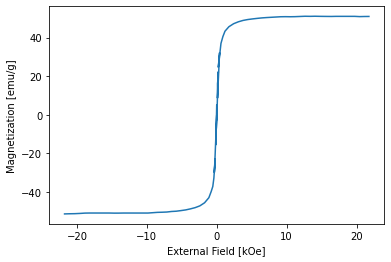

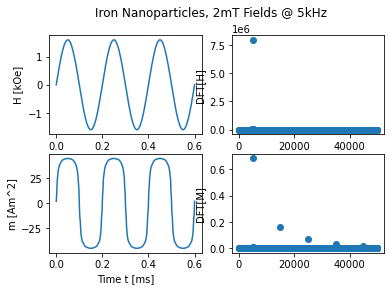

In [2]:
##############
# Compute and display magnetization & harmonics generated by saturated field
##############

from math import pi
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
mu0_num=4*pi*1e-7

#import magnetization curve of sample ()
magdata=np.genfromtxt("img/dipole_data.csv",delimiter=',')      # [emu/g] vs [kOe]
mag_f=interp1d(1e3*magdata[:,0],magdata[:,1])                   # Am^2/kg vs Oe
plt.figure(1)
plt.plot(magdata[:,0],magdata[:,1])
plt.xlabel("External Field [kOe]")
plt.ylabel("Magnetization [emu/g]")

ms=10e-6                #mass of sample
Bext=2e-3               #external magnetic flux density
Hext=Bext/mu0_num       #xternal magnetic field
fexc=5e3

mmoment=ms*mag_f(Hext)  #magnetic dipole moment of sample under external magnetic field [Am^2]

# plot the magnetic field response
T=1/fexc
times=np.linspace(0,3*T,300)
fields=Hext*np.sin(2*pi*fexc*times)
mmoments=np.array([mag_f(H) for H in fields])
fig,axes=plt.subplots(2,2)
axes[0,0].plot(1e3*times,1e-3*fields)
axes[0,0].set_ylabel("H [kOe]")
axes[1,0].plot(1e3*times,mmoments)
axes[1,0].set_xlabel("Time t [ms]")
axes[1,0].set_ylabel("m [Am^2]")
#plot the dfts
times=np.linspace(0,100*T,10000)
dt=times[1]
freqs=np.linspace(0,1/(2*dt),5000)
fields=Hext*np.sin(2*pi*fexc*times)
mmoments=np.array([mag_f(H) for H in fields])
fields_fft=np.fft.fft(fields);field_fft=fields_fft/np.linalg.norm(fields_fft)
moments_fft=np.fft.fft(mmoments);moments_fft=moments_fft/np.linalg.norm(moments_fft)
axes[0,1].plot(freqs[:1000],abs(fields_fft[:1000]),"o")
axes[0,1].set_ylabel("DFT[H]")
axes[1,1].plot(freqs[:1000],abs(moments_fft[:1000]),"o")
axes[1,1].set_ylabel("DFT[M]")
fig.suptitle("Iron Nanoparticles, 2mT Fields @ 5kHz")


### Localization Method
In order to localize the particle, a set of $n$ pickup coils with $N$ windings and vectorial surface $\mathbf{S}_{i}$ are placed around the work space.The voltage induced by the magnetic field is given by:
$$ V_{i} =  \mathbf{S}_{i} \cdot (\mathbf{H}_{ext}+\sum_{n}{\mathbf{H}}_{dip,n} )$$

In [3]:
##############
# Compute induced voltages
##############

#define the locations and surface vectors of the pickup coils
S,d,N,omega=sym.symbols("S_{coil} d N omega",real=True,positive=True)
#coil surface vector array
svecs=[]
coordvals=[-d,d]
#coil coordinates
coords=[]
for x in coordvals:
    for y in coordvals:
        for z in coordvals:
            coords.append([x,y,z])
            svecs.append(S*(x*C.i+y*C.j))

#define the voltage in coil n
voltages=[]
for i in range(0,len(coords)):
    (x,y,z)=coords[i]
    #magnetic field at position of coil
    B=center_dipole.subs([(C.x,x),(C.y,y),(C.z,z)])
    #induced voltage
    voltages.append(omega*N*B.dot(svecs[i]))

#compute numeric expressions for the voltages
substitutions={d:20e-2 , S:(5e-3)**2*pi , N:100 , omega:2*pi*fexc , mu0:4*pi*1e-7 , m:mmoment}
voltages_num=[]
for voltage in voltages:
    voltages_num.append(substitute(voltage,substitutions))

In [6]:
voltages_num[0].evalf()

-1.07032861962696e-7